In [174]:
import tabula
import pandas as pd
import os
import numpy as np
import re

In [324]:
ref_df = pd.read_csv('which_race.csv', header=0)
pdf_list = os.listdir('raw_data')
csv_list = os.listdir('race_frames')

In [53]:
counter = 34

In [305]:
d2 = {}
d3 = {}
for race_id in range(counter):
    d2['race_df_'+str(race_id)]=pd.read_csv('clean_frames/race_df_'+str(race_id)+'.csv')
    d3['pit_stop_df_'+str(race_id)]=pd.read_csv('clean_frames/pit_stop_df_'+str(race_id)+'.csv')

In [322]:
# d2['race_df_0']

In [345]:
d4={}
for race_id in range(counter):
    pit_stop_df = d3['pit_stop_df_'+str(race_id)]
    race_df = d2['race_df_'+str(race_id)]
    finishers = race_df[race_df['LAP'] == max(race_df['LAP'])]['NO'].unique()
    finishers = finishers[pd.notna(finishers)]
    race_level_df = pit_stop_df[['STOP','NO']][pit_stop_df['NO'].isin(finishers)].groupby('NO').max().reset_index()
    race_level_df['race_id'] = race_id
    race_level_df = race_level_df.merge(ref_df, on = ['race_id'], how ='inner')
    race_level_df.to_csv('clean_frames/race_level_df_'+str(race_id)+'.csv')
    d4['race_level_df_'+str(race_id)] = race_level_df

In [372]:
race_level_df = pd.read_csv('clean_frames/race_level_df_0.csv')

In [353]:
# [d4[x] in d4.keys]
# list(d4.keys())

In [357]:
pit_df = pd.concat(d4.values(),ignore_index=True)

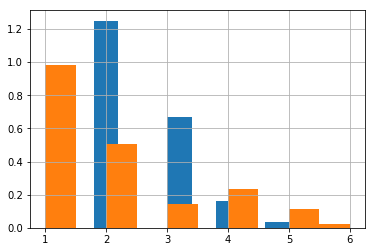

In [365]:
pit_df['STOP'][pit_df['year']==2016].hist(density=True)
pit_df['STOP'][pit_df['year']==2017].hist(density=True)


In [367]:
print(pit_df['STOP'][pit_df['year']==2016].mean(),
pit_df['STOP'][pit_df['year']==2017].mean())

2.2857142857142856 2.025925925925926


In [370]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [385]:
for i in pit_df.columns:
    print(i,pit_df[i].apply(type)[0])

NO <class 'int'>
STOP <class 'int'>
race_id <class 'int'>
year <class 'int'>
race_in_year <class 'int'>
track <class 'str'>


In [412]:
pit_df['STOP'].mode()

0    2
dtype: int64

In [422]:
pit_df['NO'] = pit_df['NO'].astype('str')#,inplace=True)

In [423]:
features_df = pd.get_dummies(pit_df[['NO','track','year']])

In [425]:
features_df['race_in_year'] = pit_df['race_in_year']

In [426]:
target = pit_df['STOP']

In [461]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.33)

In [462]:
rf_class = RandomForestClassifier(n_jobs=2, random_state=0)

In [463]:
rf_class.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [464]:
preds = rf_class.predict(X_test)

In [465]:
pd.crosstab(y_test, preds, rownames=['Actual Pits'], colnames=['Predicted Pits'])

Predicted Pits,1,2,3,4
Actual Pits,,,,
1,58,7,0,0
2,13,49,4,0
3,4,9,12,3
4,0,2,2,8
5,0,0,0,4
6,0,0,0,2


In [466]:
list(zip(X_train, rf_class.feature_importances_))

[('year', 0.09766009435996041),
 ('NO_10', 0.0013498471524653164),
 ('NO_11', 0.025797133993401816),
 ('NO_12', 0.008844661056321057),
 ('NO_14', 0.021185345017328217),
 ('NO_18', 0.01100816052764304),
 ('NO_19', 0.017350040324650047),
 ('NO_2', 0.004490375572461989),
 ('NO_20', 0.02561033913845533),
 ('NO_21', 0.00996373574437116),
 ('NO_22', 0.011125116617766051),
 ('NO_26', 0.0157865277144333),
 ('NO_27', 0.01441184532043997),
 ('NO_28', 0.0),
 ('NO_3', 0.0222469877592694),
 ('NO_30', 0.017058235912809805),
 ('NO_31', 0.007528306240192702),
 ('NO_33', 0.028595216753650392),
 ('NO_36', 0.0),
 ('NO_39', 0.0027769428843216195),
 ('NO_44', 0.02098616105450217),
 ('NO_47', 0.0),
 ('NO_5', 0.018952414971498237),
 ('NO_55', 0.012725667507118534),
 ('NO_6', 0.020482995828185992),
 ('NO_7', 0.026683267759575514),
 ('NO_77', 0.030932492292274016),
 ('NO_8', 0.02209019532283034),
 ('NO_88', 0.0016145364923063187),
 ('NO_9', 0.029387380712556872),
 ('NO_94', 0.022585754390312896),
 ('track_ Mon

In [467]:
from sklearn.metrics import accuracy_score

In [468]:
accuracy_score(y_test, preds)

0.7175141242937854

In [469]:
accuracy_score(y_test, np.ones(177,)*(y_train.mode().values[0]))

0.3728813559322034

In [446]:
# dfs = []
# counter = 0
# for _pdf in os.listdir('raw_data'):
#     if (_pdf.lower().endswith(('.pdf'))) & ('history' in _pdf.lower()):
#         _name ='history_chart_'+str(counter)+'_df'
#         print(type(_name))
#         counter+=1
# #         print(_pdf)
# #         print(_name)
#         dfs.append(_name)
#         exec( _name+" = tabula.read_pdf('raw_data/'+_pdf,pages='all')")
#         exec(_name+".to_csv('race_frames/'+_name+'.csv')")

# def pdf_to_csv(race_id):
#     '''
#     takes a race_id number as argument
#     gets the appropriate pdf files from '/raw_data'
#     read them into df's
#     saves the df's into csvs in '/race_frames'
#     '''
#     year = ref_df[ref_df['race_id']==race_id]['year'].values[0]
#     race_in_year = ref_df[ref_df['race_id']==race_id]['race_in_year'].values[0]
#     correction = len(str(race_in_year))
#     for _pdf in pdf_list:
#         if (_pdf.lower().endswith(('.pdf'))) & ('jpg' not in _pdf.lower()) & (_pdf.lower().startswith(str(year))) & (_pdf.lower()[5:].startswith(str(race_in_year)+'_')):
#             print('year is ',year)
#             print('race_id is ',race_id)
#             print('race_in_year',race_in_year,':',correction)
#             print(_pdf)
#             if ('history' in _pdf.lower()):
# #         if (_pdf.lower().endswith(('.pdf'))) & ('jpg' not in _pdf.lower()) & (_pdf.lower().startswith(str(year))) & (_pdf.lower()[5:].startswith(str(race_in_year))):
#                 print(_pdf[6+correction:])
#                 _name = _pdf[6+correction:-4]+'_'+str(race_id)+'_df'
#                 exec( _name+" = tabula.read_pdf('raw_data/'+_pdf,pages='all')")
#                 exec(_name+'["race_id"] = race_id')
#                 exec(_name+".to_csv('race_frames/'+_name+'.csv')")
#                 print(_name)
#              elif ('stop' in _pdf.lower())):
#     return None


# ref_df[ref_df['race_id']==4]['race_in_year'].values[0]

# # race_id = 2
# year = ref_df[ref_df['race_id']==race_id]['year'].values[0]
# race_in_year = ref_df[ref_df['race_id']==race_id]['race_in_year'].values[0]
# correction = len(str(race_in_year))
# for _pdf in os.listdir('raw_data'):
#     if (_pdf.lower().endswith(('.pdf'))) & ('jpg' not in _pdf.lower()) & (_pdf.lower().startswith(str(year))) & (_pdf.lower()[5:].startswith(str(race_in_year))) & ( ('history' in _pdf.lower()) | ('stop' in _pdf.lower())):
# #         print(_pdf[6+correction:])
#         exec( _name+" = tabula.read_pdf('raw_data/'+_pdf,pages='all')")
#         _name = _pdf[6+correction:-4]+'_'+str(race_id)+'_df'
#         exec(_name+'["race_id"] = race_id')
#         exec(_name+".to_csv('race_frames/'+_name+'.csv')")
# #         print(_name)